This notebook contains preproccessing and analysis of EEG recordings collected in a go/no-go task. In the task, participants were instructed to perform a button press, when getting a certain auditory cue ("go" signal). During some of these trials, the partcipant would get a different auditory cue ("no-go" signal), and would then have to inhibit their response.

In this notebook, data from two participants are preproccesed. For the analysis, a logistic regression is cross-validated for the first participant. Then the model is fitted to recordings from first participant and used to predict activation from participant two. The performance of the model is briefly commented on. 

*NB: As the preprocessing steps for partcipant 2 follow the exact same structure as for participant 1, only preprocessing of participant 1 is thoroughly commented. Thus, only few comments are added in the section on participant two.*

## Overview
- Load modules and data
- Preprocessing
    - Filtering
    - Artefact corrections
    - Epoching
    - Evoked signals
    - Preprocessing for participant 2 (not commented)
- Decoding analysis
    - Get data
    - Defining model
    - Fitting model
    - Predicting participant 2
    - Assessing statistical significance

## Load modules and data

In [178]:
%matplotlib inline

In [248]:
# import modules
import mne
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from scipy.stats import binom_test

from mne.decoding import (SlidingEstimator,
                          cross_val_multiscore, LinearModel, get_coef)

from trigger_function import convert_triggers

In [180]:
# import data (placed in the data folder)
filepath_p1 = os.path.join("..", "data", "p1-raw.fif")
filepath_p2 = os.path.join("..", "data", "p2-raw.fif")

raw1 = mne.io.read_raw_fif(filepath_p1, preload=True)
raw2 = mne.io.read_raw_fif(filepath_p2, preload=True)
# preload=True to load into memory - needed for filtering

raw1.load_data()
raw2.load_data()

Opening raw data file ..\data\p1-raw.fif...
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.
Reading 0 ... 1214579  =      0.000 ...  1214.579 secs...
Opening raw data file ..\data\p2-raw.fif...
    Range : 0 ... 989399 =      0.000 ...   989.399 secs
Ready.
Reading 0 ... 989399  =      0.000 ...   989.399 secs...


<Raw | p2-raw.fif, 32 x 989400 (989.4 s), ~241.6 MB, data loaded>

## Preprocessing

The preprocessing of the two files (raw1 and raw2) will be done separately. First, all the preproccessing steps will be applied to the first partcipant. Then the same steps will be repeated for participant 2. Preproccessing for participant 1 will be thoroughly commented, whereas preproccessing for participant 2 won't include as many comments.

### Filtering
- Lowpass: 40Hz
- Highpass: 0.1Hz (following convention)

The low pass filter is chosen to be 40Hz too exclude line noise. The data has been collected in Denmark where the line noise is typically at 50Hz. Following convention, highpass filter of 0.1Hz is chosen.

We first apply the lowpass filter and then the highpass filter, instead of applying both simultaniously. This is done as the calculation of the Fourier coefficients are done differently in the two processes. The two-step process produces less artefacts, thus, we have chosen to do so.

In [181]:
filtered = raw1.copy().filter(l_freq=None, h_freq=40)
filtered = filtered.filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)



In [182]:
filtered.info  # checking that filters have the desired effect

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

Effective window size : 2.048 (s)


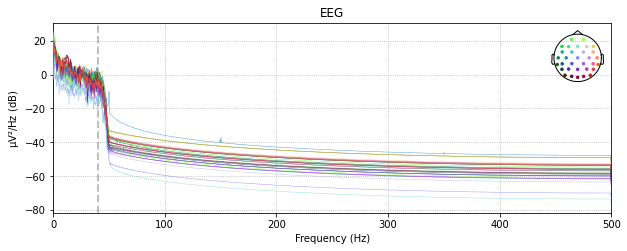

In [183]:
# plotting amplitude (y-axis), channels (colors), and frequency (x-axis)
filtered.plot_psd(area_mode='range', tmax=10.0, average=False);

We visually inspect the filtering. The dashed line represent 40Hz. To reduce ringing in the signal, the cut-off is not a hard cut-off, which can be seen in the plot. 

### Artefact corrections
- Identify bad channels
- Independent Component Analysis (ICA)

To remove artefacts from the signal, we both inspect the data, to identify any bad channels, and apply an ICA.

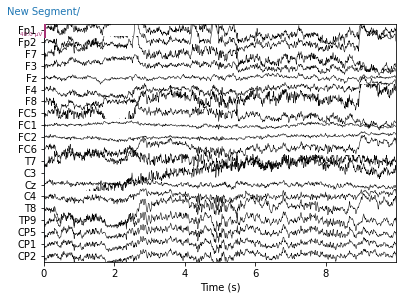

In [184]:
# plot signal from the different channels, to identify bad channels
filtered.plot(show_scrollbars=False);

When plotting the signal from the different channels, it seems that there is a drift in channel C3. Based on this, we have decided to define C3 as a bad channel.

In [185]:
# define bad channel: C3
filtered.info['bads'] = ['C3']
filtered.info

<Info | 13 non-empty values
 bads: 1 items (C3)
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

#### Independent Component Analysis (ICA)

The purpose of the ICA is to find regular components in the signal across time and channels. These components can be eyeblinks or muscles tension, which we want to exclude from further analysis.

We have chosen to include as many components in the ICA needed for 95% of the variance to be explained.  The components are ordered by how much variance they explain (from most to least variance). After fitting the ICA, we visually inspect the individual components to decide which components to exclude.

In [186]:
# set up and fit the ICA
# n_components until 95% of variance is explained
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(filtered)

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 11 components
Fitting ICA took 13.3s.


<ICA | raw data decomposition, fit (fastica): 1214580 samples, 11 components, channels used: "eeg">

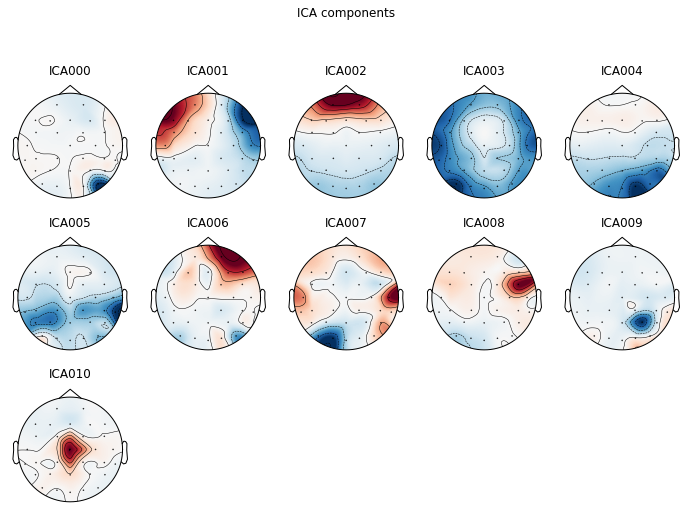

In [187]:
# plot ICA components topography
ica.plot_components();

Creating RawArray with float64 data, n_channels=11, n_times=1214580
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.


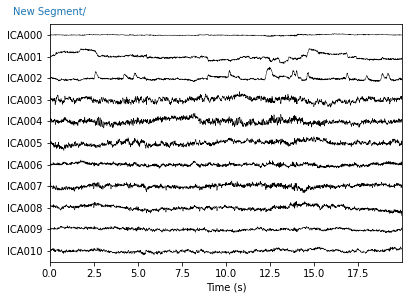

In [188]:
# plotting ICA component timeseries
ica.plot_sources(filtered, show_scrollbars=False);

As eyeblinks and saccades happen fairly frequently, they are often big explainers of varianc, thus, resulting in them often being among the first components. We want to exclude components that maps eyeblinks, saccades or other activity not induced by neural activity.

From plotting the topography and the timeseries of the individual components, we conclude that component 0 being muscle tension, 1 being saccades, and 2 being eyeblinks are likely. We plot the properties of the three components (0, 1, and 2) to further inspect the components.

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


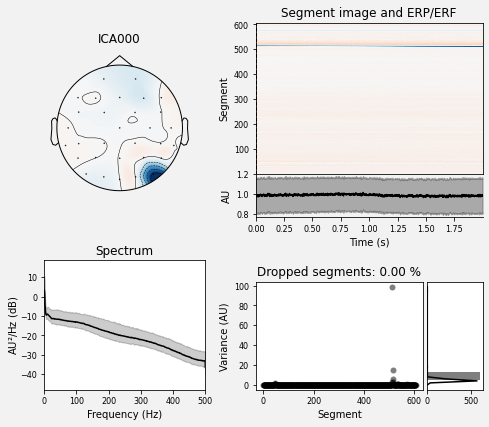

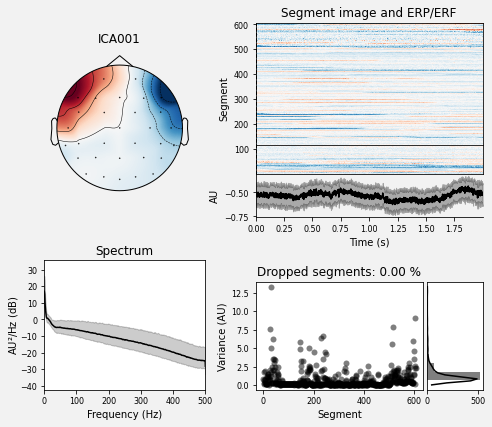

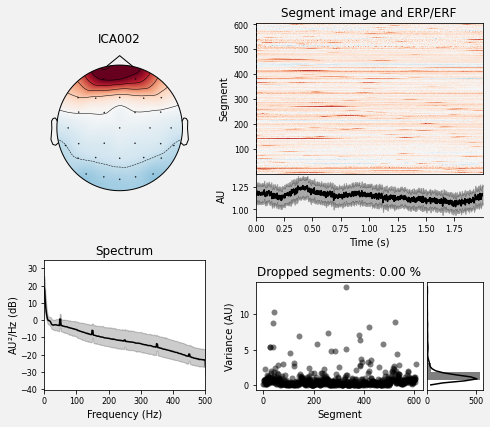

In [189]:
# Plotting properties of components we want to exclude.
ica.exclude = [0, 1, 2] 
ica.plot_properties(raw1, picks=ica.exclude);

In [190]:
# Applying the ICA 
# (we can reconstruct the sensor signals
# with artifacts removed using the apply method)

orig_filtered = filtered.copy()  # saving a copy of the original data

ica.apply(filtered)

Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 3 ICA components
    Projecting back using 31 PCA components


<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

We now visually compare signal from the channels before and after applying ICA.

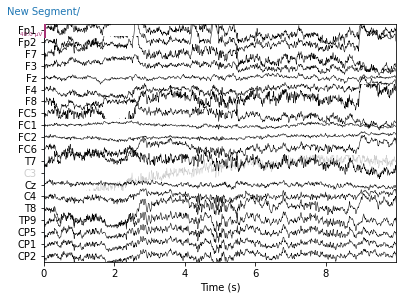

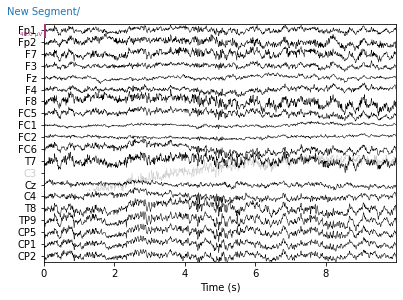

In [191]:
orig_filtered.plot(start=0, duration=10, scalings=20e-6, show_scrollbars=False);
filtered.plot(start=0, duration=10, scalings=20e-6, show_scrollbars=False);

Peaks in the signal that could resemble eyeblinks (or an other artefact) have been removed in the signal after applying ICA.

### Epoching
- Recoding trigger values
- tmin: -0.5, tmax: 1.5
- Reject all epochs with signal over 150 µV
- Baseline: (None, 0)

We now create the epochs. We firstly recode the events, so that we know which trials resulted in successful or failed inhibition. The epochs are time locked around the time of the events, and 0.5 seconds before to 1.5 seconds after the event is included (thus the event occurs at time point 0). The activity from before the event (-0.5 to 0) is used for baseline correction.

In [192]:
# extracting events from annotations
events, _ = mne.events_from_annotations(filtered)

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 20']


In [193]:
# convert triggers according subsequent actions of the participants
# using function provided by Mads Jensen
events, event_id = convert_triggers(events, return_event_ids=True)

In [194]:
print(events)  
# first column represented timepoint in ms, 
# while the third column represents event id

print(event_id)  
# what event the event ids represent

[[      0       0   99999]
 [  60957       0      10]
 [ 142467       0       1]
 ...
 [1002958       0      10]
 [1003258       0       1]
 [1004718       0      12]]
{'stop_signal': 11, 'go': 10, 'response': 1, 'stop_signal_only': 12, 'failed_response': 2, 'failed_inhibition': 37, 'successful_inhibition': 35}


C:\Users\Sara\AppData\Local\Temp/ipykernel_22016/3204258702.py:2: RuntimeWarning: event 30 missing from event_id will be ignored
  mne.viz.plot_events(events,
C:\Users\Sara\AppData\Local\Temp/ipykernel_22016/3204258702.py:2: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events,


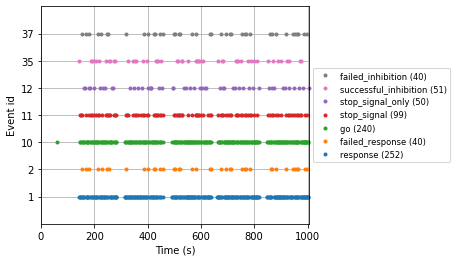

In [195]:
# visualize events over time
mne.viz.plot_events(events,
                    sfreq=filtered.info['sfreq'],  # sample frequency is 1000 Hz
                    first_samp=filtered.first_samp, 
                    event_id=event_id);

The plots shows that there are around the same number of successful and failed inhibition trials and that they are distributed fairly equally across time.

We now specity which epochs we want to exclude according to our reject criteria. This is done to remove epochs that include signal that is most likely not generated by neural activity. The reject criteria depend on the method used for obtaining the data. The convention for EEG is 150 µV, thus, this is the reject criteria used for this analysis. By using a relativily high thresshold, we avoid rejecting to much of our data, which is necessary as only data from two participants have been collected.


In [196]:
reject = dict(eeg=150e-6) # reject all epoch with signal over 150 µV
tmin, tmax = -0.5, 1.5

# now the epochs are created
epochs = mne.Epochs(filtered, events, event_id, tmin, tmax,
                    baseline=(None, 0), reject=reject, preload=True)

Not setting metadata
Not setting metadata
772 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 772 events and 2001 original time points ...
    Rejecting  epoch based on EEG : ['P8', 'O2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['P4']
7 bad epochs dropped


In [197]:
epochs  
# after rejection there are 40 failed inhibition trials, 
# and 50 successful inhibition

Number of events,765
Events,failed_inhibition: 40failed_response: 40go: 238response: 250stop_signal: 98stop_signal_only: 49successful_inhibition: 50
Time range,-0.500 – 1.500 sec
Baseline,-0.500 – 0.000 sec


### Evoked signals
- Define relevant conditions: succesful and failed inhibition
- Equalize event counts between the two conditions to balance the dataset
- Average over epochs for the two conditions separately

In [198]:
conds_we_care_about = ['successful_inhibition', 'failed_inhibition']

In [199]:
# making sure we have equal number of trials in each 
# condition to have a balanced dataset
# both conditions will contain 40 trials
epochs.equalize_event_counts(conds_we_care_about)

# extracting epochs for sucessful and failed inhibition
suc_epochs = epochs['successful_inhibition']
fail_epochs = epochs['failed_inhibition']

Dropped 10 epochs: 55, 117, 129, 135, 174, 180, 184, 389, 395, 400


We now visualize epochs over time from different channels (here only Fp1 is demonstrated). Above on the plot, the signal magnitude (color) for all epochs (y-axis) over time (x-axis) is demonstrated. The bottom part of the plot show the evoked signal (i.e. the averaged signal).

Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


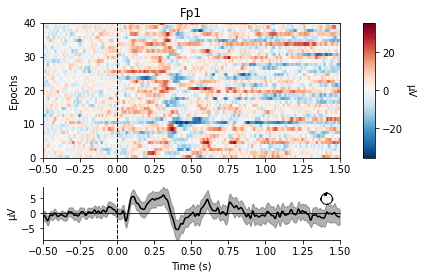

In [200]:
suc_epochs.plot_image(picks=['Fp1']);

Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


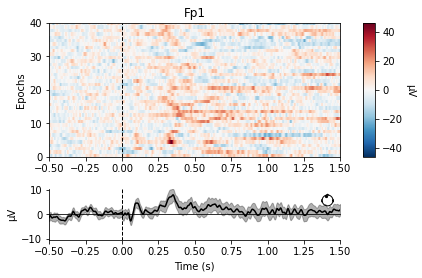

In [201]:
fail_epochs.plot_image(picks=['Fp1']);

#### Calculate evoked signals. 
We now calculate the evoked signals by averaging the epochs.

In [202]:
suc_evoked = suc_epochs.average()
fail_evoked = fail_epochs.average()

Signals from the different channels together with the global field power (gfp) is visualized below. The gfp is the spatial standard deviation at each timepoint, i.e., large gfp represents large variance in signal between the channels.

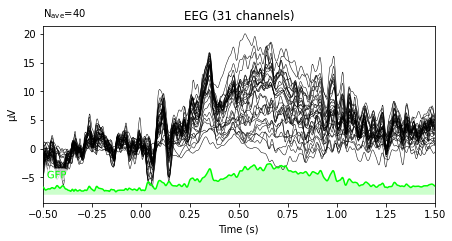

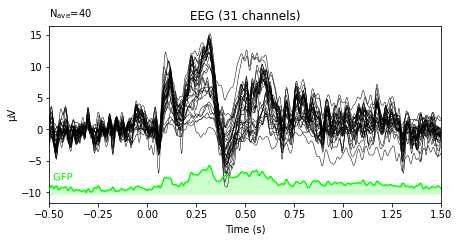

In [203]:
fail_evoked.plot(gfp=True); 
suc_evoked.plot(gfp=True);

Comonly for both conditions, the early components of the signal are fairly similar (right around the go signal). For the failed trails, the gfp grows for later components, thus, the signal across epochs vary more. The same is not found for the successful trials, where the signal stays more similar between different epochs.

Lastly, we visually compare the two evoked signals.

combining channels using "gfp"
combining channels using "gfp"


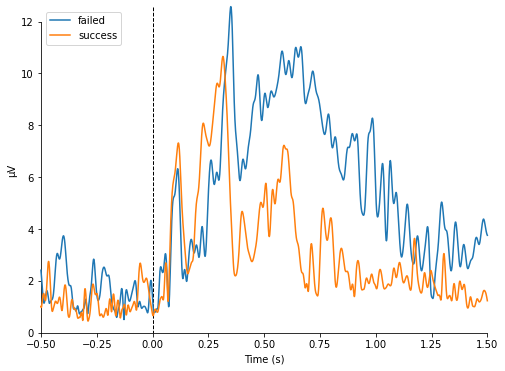

[<Figure size 576x432 with 1 Axes>]

In [204]:
# comparison of the two evoked signals
mne.viz.plot_compare_evokeds(evokeds=dict(failed=fail_evoked, success=suc_evoked))

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


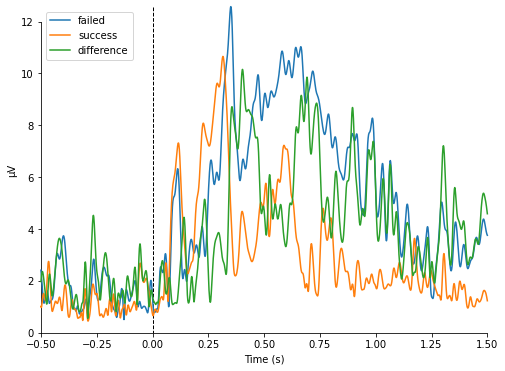

[<Figure size 576x432 with 1 Axes>]

In [205]:
# add difference wave
difference_wave = mne.combine_evoked([fail_evoked, suc_evoked], weights = [1,-1])
mne.viz.plot_compare_evokeds(evokeds=dict(failed=fail_evoked,
                                          success=suc_evoked, 
                                          difference=difference_wave))

The difference between conditions seems fairly small at and before stimulus onset (timepoint 0) as one would expect. Right after stimulus onset the signals continue to be be similar across the two conditions. Around 300-1,100 ms the difference wave gets bigger, thus, indicating a noticeable difference in activity between conditions. 

To get a more detailed view, we have plotted the same including the the individual channels.

No projector specified for this dataset. Please consider the method self.add_proj.


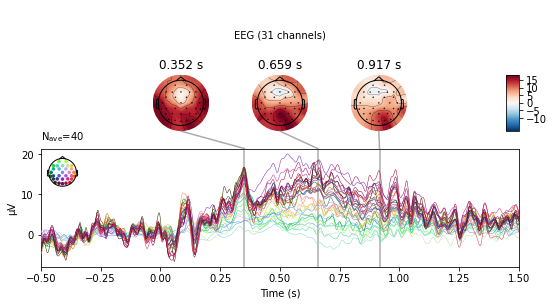

No projector specified for this dataset. Please consider the method self.add_proj.


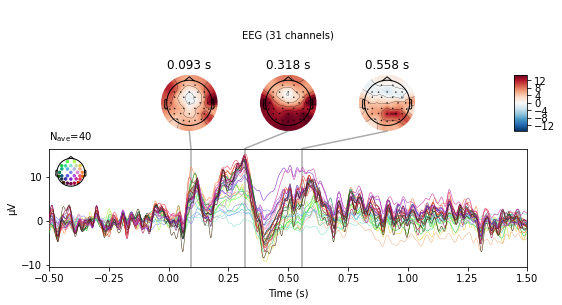

In [206]:
fail_evoked.plot_joint();
suc_evoked.plot_joint();

No projector specified for this dataset. Please consider the method self.add_proj.


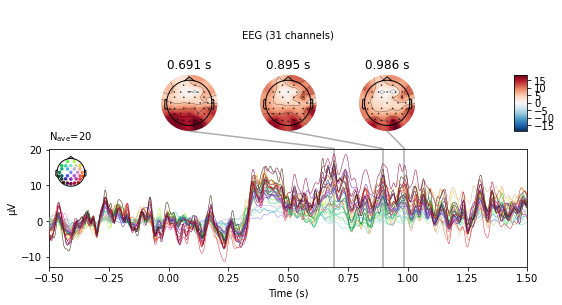

In [207]:
difference_wave.plot_joint();

### Preprocessing for participant 2

The same preprocessing steps as were performed on the data from participant 1 will now be applied to the data from participant 2. This part will not be as thoroughly commented as the preprocessing for participant 1.

#### Filtering

In [208]:
filtered2 = raw2.copy().filter(l_freq=None, h_freq=40)
filtered2 = filtered2.filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)



#### Artefact corrections

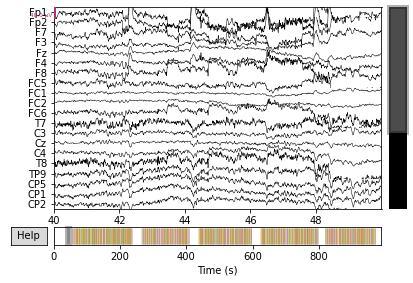

In [209]:
filtered2.plot(start=40, show_scrollbars=False); 
# no bad channels

In [210]:
ica2 = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica2.fit(filtered2)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by explained variance: 10 components
Fitting ICA took 18.9s.


<ICA | raw data decomposition, fit (fastica): 989400 samples, 10 components, channels used: "eeg">

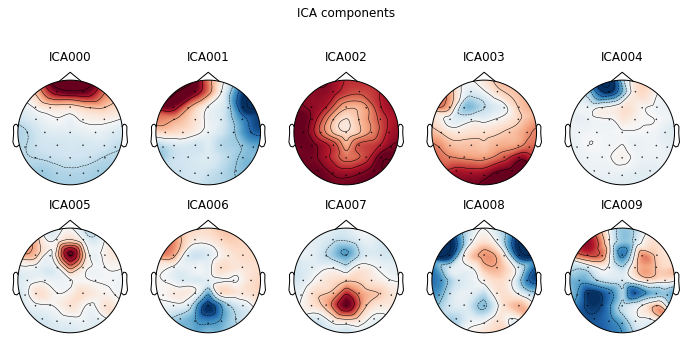

In [211]:
ica2.plot_components();

Creating RawArray with float64 data, n_channels=10, n_times=989400
    Range : 0 ... 989399 =      0.000 ...   989.399 secs
Ready.


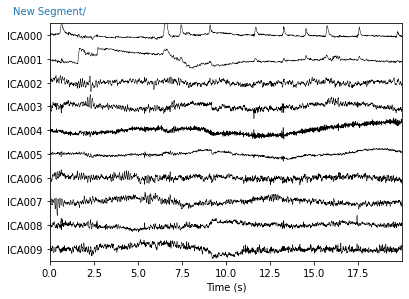

In [213]:
ica2.plot_sources(filtered2, show_scrollbars=False);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


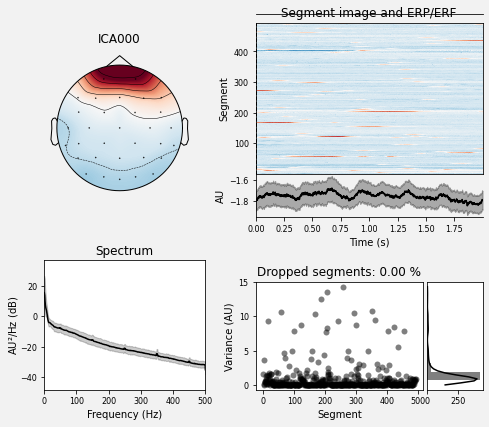

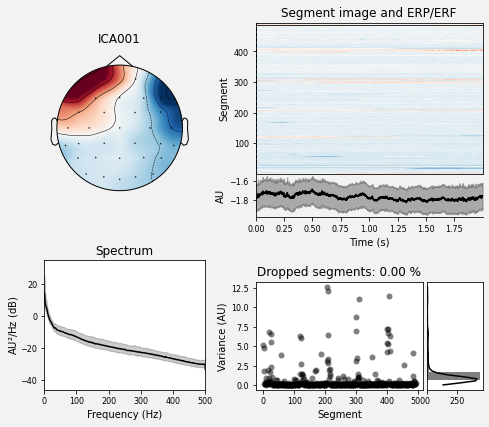

In [215]:
# Exclude components 0, and 1
ica2.exclude = [0, 1] 
ica2.plot_properties(raw2, picks=ica2.exclude);

# 0: Eye blink, 1: saccade

In [216]:
# apply ICA
orig_filtered = filtered2.copy()
ica2.apply(filtered2)

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


<Raw | p2-raw.fif, 32 x 989400 (989.4 s), ~241.6 MB, data loaded>

#### Epoching

In [217]:
events2, _ = mne.events_from_annotations(filtered2)

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 20']


In [218]:
events2 = convert_triggers(events2, return_event_ids=False)

C:\Users\Sara\AppData\Local\Temp/ipykernel_22016/3295647710.py:2: RuntimeWarning: event 30 missing from event_id will be ignored
  mne.viz.plot_events(events2,
C:\Users\Sara\AppData\Local\Temp/ipykernel_22016/3295647710.py:2: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events2,


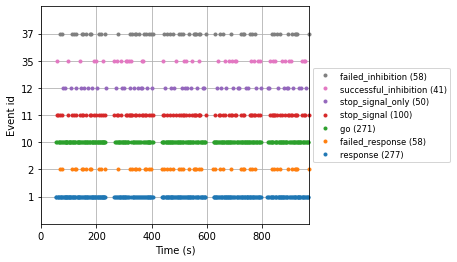

In [219]:
# visualize events
mne.viz.plot_events(events2,
                    sfreq=filtered2.info['sfreq'], 
                    first_samp=filtered2.first_samp, 
                    event_id=event_id);

# approx. same number of successful and failed inhibition, 
# distributed equally across time

In [220]:
# reject all epoch with signal over 150 µV
reject = dict(eeg=150e-6)

tmin, tmax = -0.5, 1.5

epochs2 = mne.Epochs(filtered2, events2, event_id, tmin, tmax,
                    baseline=(None, 0), reject=reject, preload=True)

Not setting metadata
Not setting metadata
855 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 855 events and 2001 original time points ...
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10', 'P7', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10', 'P7', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO9', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['PO9', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'PO10']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'PO10']
    Rej

#### Evoked

In [221]:
conds_we_care_about = ['successful_inhibition', 'failed_inhibition']

In [222]:
epochs2.equalize_event_counts(conds_we_care_about)
suc_epochs2 = epochs2['successful_inhibition']
fail_epochs2 = epochs2['failed_inhibition']

Dropped 14 epochs: 20, 65, 72, 100, 112, 317, 350, 359, 373, 402, 431, 454, 461, 478


In [223]:
suc_evoked2 = suc_epochs2.average()
fail_evoked2 = fail_epochs2.average()

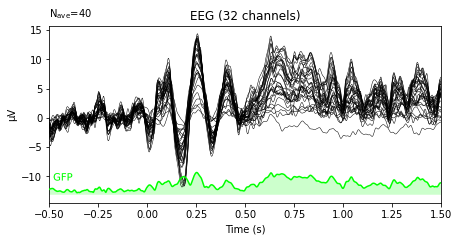

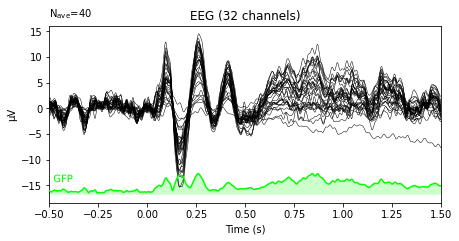

No projector specified for this dataset. Please consider the method self.add_proj.


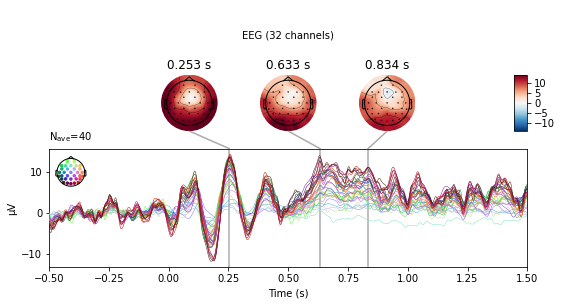

No projector specified for this dataset. Please consider the method self.add_proj.


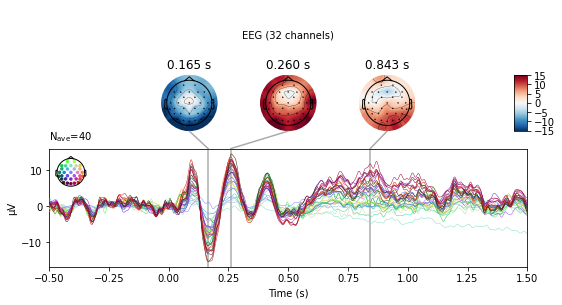

In [225]:
suc_evoked2.plot(gfp=True);
fail_evoked2.plot(gfp=True);

suc_evoked2.plot_joint();
fail_evoked2.plot_joint();

combining channels using "gfp"
combining channels using "gfp"


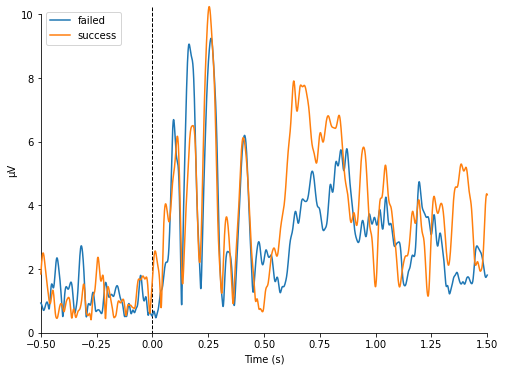

[<Figure size 576x432 with 1 Axes>]

In [226]:
mne.viz.plot_compare_evokeds(evokeds=dict(failed=fail_evoked2, success=suc_evoked2))

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


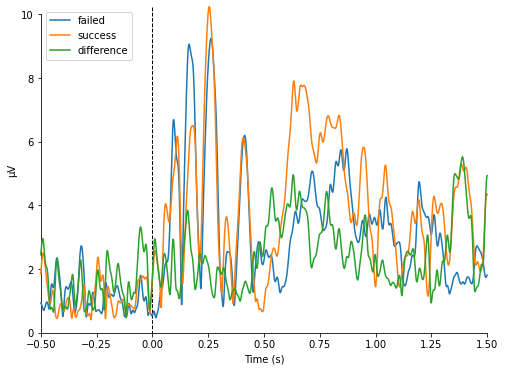

No projector specified for this dataset. Please consider the method self.add_proj.


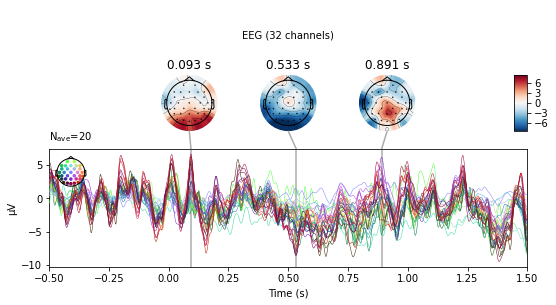

In [227]:
# add difference wave
difference_wave2 = mne.combine_evoked([fail_evoked2, suc_evoked2], weights = [1,-1])
mne.viz.plot_compare_evokeds(evokeds=dict(failed=fail_evoked2,
                                          success=suc_evoked2, 
                                          difference=difference_wave2))

difference_wave2.plot_joint();

## Decoding Analysis

We have decided to analyse the data using decoding. We have chosen to use a logistic regression to classify whether an epoch belongs to a trial with successful or failed inhibition. 

Firstly, we crossvalidate the model only using data from participant one. This is done in 5 splits on each time point. Secondly, we use all of the data from participant 1 to fit the model, and inspect the coefficients of this model. Thirdly, we predict data from participant 2 with the model fitted on the data from participant 1, to see if the model generalizes across participants.

### Get data
- X: Matrix of the data from participant 1
- y: A vector of the correct event ids

In [228]:
# Only include same epochs: successful and failed inhibition
X = epochs[conds_we_care_about].get_data()  
y = epochs[conds_we_care_about].events[:, 2]

In [229]:
print(X.shape, # X-dimension: n_epochs, n_channels, n_times
      y.shape) # epochs

(80, 32, 2001) (80,)


In [230]:
# change event ids to 0 and 1
y[y==35] = 0  # succesful
y[y==37] = 1  # failed

### Defining model
- Crossvalidation (cv)
- Classifier (clf)
- Sliding estimator (time_decod)

For crossvalidation we use 5 splits where each of the splits contain a test set, which includes 20% of the data. The classifier pipeline firstly scales the datapoints (z-score scaling), and then runs a logistic regression wrapped in a linear model. The sliding estimator is used so that the classifier pipeline is applied to the data at every timepoint. As performance metric we use receiver operating characteristic (ROC) area under the curve (AUC).

In [58]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=2021)

clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression()))

# for each timepoint apply clf
time_decod = SlidingEstimator(clf, scoring='roc_auc')

### Fitting model
- Fit scores using crossvalidation
- Plot the ROC AUC scores for each timepoint
- Get pattern coefficients from model fitted on participant 1

In [231]:
scores = cross_val_multiscore(time_decod, X, y, cv=cv)

100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:39<00:00,   50.18it/s]
100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:42<00:00,   46.65it/s]
100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:28<00:00,   70.37it/s]
100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:28<00:00,   69.60it/s]
100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:24<00:00,   82.34it/s]


In [247]:
scores.shape  
# scores-dimension: n_folds (5), n_timepoints (2001)

# performance measure for each timepoint in each split

(5, 2001)

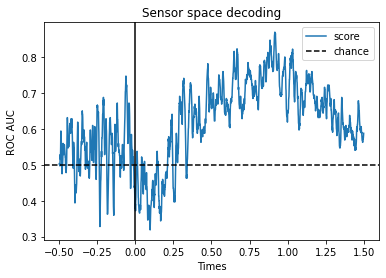

In [233]:
# Mean scores across cross-validation splits 
# (we only want one score for each timepoint)
scores_mean = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores_mean, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('ROC AUC') 
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()

The predictions of the model lies around chance for early time points. For later time points (around 300-1,100 ms) the predictions of the model get more accurate. The predictions of the model seems to be most accurate around 900 ms. This finding corresponds well with the indications from visually inspecting the difference wave between the evoked signals.

#### Fitting the model to the entire dataset of participant 1

In [234]:
time_decod = SlidingEstimator(clf, scoring='roc_auc')

time_decod.fit(X, y)

100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:36<00:00,   55.28it/s]


<SlidingEstimator(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearmodel', LinearModel(model=LogisticRegression()))]),
         n_jobs=1, scoring='roc_auc', verbose=None, fitted with 2001 estimators>

#### Finding the patterns that drive the classification

To enable direct interpretation, we look at the inverse transformed pattern coefficients. By using a inverse transformation, the coefficients are transformed from standardized estimates to µV. The coefficient patterns represent how activation at different time points and channels drive the prediction towards class 1 (i.e. failed inhibition). Thus, high activation at time points and channels with higher coefficients will push the classification towards class 1.

In [235]:
coef = get_coef(time_decod, 'patterns_', inverse_transform=True) 
# inverse_transform=True to transform coef back to µV

In [236]:
coef.shape # 32 channels, 2001 timepoints

(32, 2001)

No projector specified for this dataset. Please consider the method self.add_proj.


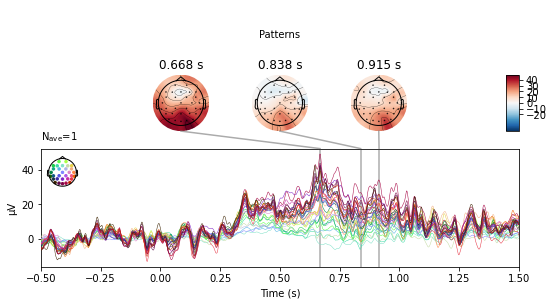

In [238]:
evoked_coef = mne.EvokedArray(coef,
                              epochs.info,
                              tmin=epochs.times[0],
                        )

evoked_coef.plot_joint(title='Patterns'); 

Visally inspecting the inverse transformed pattern coefficients. The different linecolors represent the channels, the x-axis represent time and y-axis represent the size of the coefficients (after inverse transform). 

The coefficients for the different channels are fairly similar at early time points. In the timeperiod between 300-1,100 ms the size of the coefficients change across channels. Many of the channels have higher coefficients at this timeperiod, meaning that higher positive activation at these channels (in this timeperiod) would push the prediction towards classifying the trial as failed inhibition, while a lower or a negative activation, would push the prediction towards classifying the trial as successful inhibition. Given what we have previously seen, it makes sense that the model are able to make a stronger distinction between the two conditions in this timeperiod.

### Predicting participant 2

In [241]:
# prepare data to predict participant 2
X2 = epochs2[conds_we_care_about].get_data()  
y2 = epochs2[conds_we_care_about].events[:, 2] 

# change event ids to 0 and 1
y2[y2==35] = 0  # succesful
y2[y2==37] = 1  # failed

In [242]:
y2_pred = time_decod.predict(X2)  # predictions

100%|██████████| Transforming SlidingEstimator : 2001/2001 [00:00<00:00, 2242.45it/s]


In [244]:
y2_pred.shape  # 80 trials, 2001 timepoints

(80, 2001)

In [245]:
pred_scores = []
for pred in y2_pred.T:  # transpose pred to get all preds at each timepoint
    pred_scores.append(roc_auc_score(y2, pred))

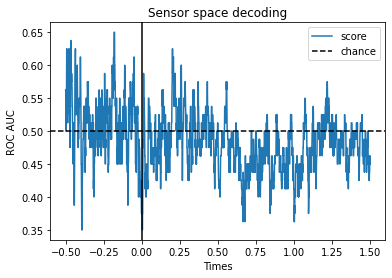

In [246]:
# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, pred_scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('ROC AUC') 
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()

Generally, the model fitted on data from participant 1 doesn't predict data from participant 2 better than chance. This indicates, that the patterns from participant 1 doesn't generalize to participant 2. This could be caused by both individual neural activation patterns but also other arbitrary differences when recording the signal (such as the placement of the EEG cap). To make the model more robust to these differences, one would want to fit the model on data from multiple participants before predicting signal from a single participant. 

### Assessing statistical significance

Lastly, we want to assess whether the models fitted to data from participant 1 predict significantly better than chance - and at what time points.

In [250]:
# calculate p-values at each time point 
p_values = []
for score in scores_mean:
    # number of correct predictions is calculated from ROC AUC score
    n_correct = 80*score
    p = binom_test(n_correct, 80, alternative="greater")
    p_values.append(p)

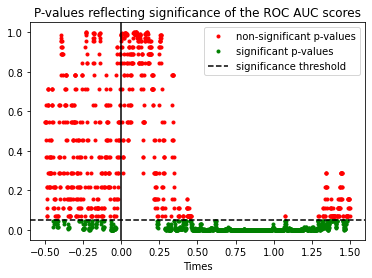

In [273]:
# plot
fig, ax = plt.subplots()
# p values are color-coded according to significance
ax.plot(epochs.times[np.array(p_values) >= 0.05], 
        np.array(p_values)[np.array(p_values) >= 0.05], 
        'r.', label='non-significant p-values')
ax.plot(epochs.times[np.array(p_values) < 0.05], 
        np.array(p_values)[np.array(p_values) < 0.05], 
        'g.', label='significant p-values')
ax.axhline(.05, color='k', linestyle='--', label='significance threshold')
ax.set_xlabel('Times') 
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('P-values reflecting significance of the ROC AUC scores')
plt.show()

##### NB: The p-values are not corrected for multiple comparisons

As there have been calculated a p-values for every time point and the p-values have not corrected for multiple comparisons, we should be cautious about interpreting significance of the predictions. By not correcting for multiple comparisons the false positive rate is likely to increase. Before stimulus onset we see a number of models that predict significantly better than chance, and this is possibly due to the lack of correction.

At the timeperiod between 500-1,200 ms, a vast majority of models predict significantly better than chance. This finding corresponds well with previous findings in the analysis.